In [93]:
import os
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time 
import torchvision.models as models
from matplotlib import pyplot as plt 
from torch.utils.data import DataLoader

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Tranformation and Loading Data

In [95]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.RandomAdjustSharpness(1.5, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])

])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),     
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   
])

In [96]:
train_dataset = datasets.ImageFolder(root = r"D:\Machine learning\deep learning\CNN_pneumonia_Project\cnn_diseases\Datasets\train",transform=train_transforms)
test_dataset = datasets.ImageFolder(root = r"D:\Machine learning\deep learning\CNN_pneumonia_Project\cnn_diseases\Datasets\test",transform=test_transforms)

In [97]:
class_names = train_dataset.classes
class_names

['NORMAL', 'PNEUMONIA']

### Making the Dataloader

In [98]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle= True,num_workers=2)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle= False,num_workers=2)

In [99]:
for image,label in train_loader:
    print(image.shape)
    print(label.shape)
    break

torch.Size([32, 1, 224, 224])
torch.Size([32])


In [100]:
label[0]

tensor(1)

In [101]:
image[0].shape

torch.Size([1, 224, 224])

In [102]:
image[0].permute(1,2,0).shape 

torch.Size([224, 224, 1])

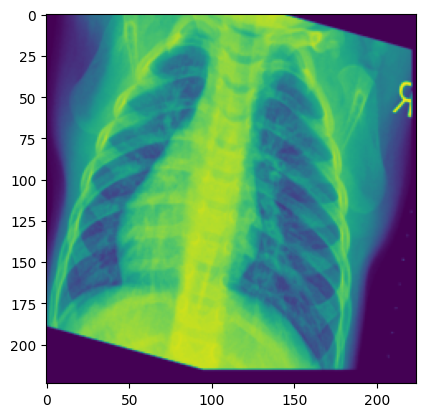

In [103]:
plt.imshow(image[8].permute(1,2,0))
plt.show()

### CNN MODEL

In [104]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetClassifier(nn.Module):
    def __init__(self, num_classes, resnet_version=50, dropout_rate=0.5, trainable_layers=1, input_channels=3):
        super().__init__()

        
        if resnet_version == 18:
            self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        elif resnet_version == 34:
            self.model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        elif resnet_version == 50:
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        elif resnet_version == 101:
            self.model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        elif resnet_version == 152:
            self.model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
        else:
            raise ValueError("Unsupported ResNet version!")

        
        if input_channels != 3:
            old_conv = self.model.conv1
            self.model.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
            if input_channels == 1:  
                self.model.conv1.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)
            else:  
                self.model.conv1.weight.data = old_conv.weight.data[:, :input_channels, :, :]

        
        for param in self.model.parameters():
            param.requires_grad = False

        
        layer_list = [self.model.layer4, self.model.layer3, self.model.layer2, self.model.layer1]
        for i in range(trainable_layers):
            for param in layer_list[i].parameters():
                param.requires_grad = True

        
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)



In [105]:
def train_model(model, optimizer, criterion, train_loader, test_loader, device, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_no, (image, labels) in enumerate(train_loader):
            image = image.to(device)
            labels = labels.to(device)

            # forward pass
            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output, labels)

            # backward pass
            loss.backward()
            optimizer.step()

            if (batch_no + 1) % 10 == 0:
                print(f"Batch: {batch_no+1}, Epoch: {epoch+1}, Loss: {loss.item():.2f}")

            running_loss += loss.item() * image.size(0)

        # Epoch average loss
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for image, label in test_loader:
                image, label = image.to(device), label.to(device)
                output = model(image)
                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()
                all_labels.extend(label.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total
        print(f"** Validation Accuracy: {accuracy:.2f}% **\n")

    return all_labels, all_predictions


In [106]:
model_resnet = ResNetClassifier(
    num_classes=2,
    resnet_version=50,
    dropout_rate=0.5324151512537223,
    trainable_layers=2,
    input_channels=1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_resnet.parameters()), lr=0.000560530853961576)


In [107]:
all_labels, all_predictions = train_model(
    model=model_resnet,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    epochs=5
)

Batch: 10, Epoch: 1, Loss: 0.23
Batch: 20, Epoch: 1, Loss: 0.11
Batch: 30, Epoch: 1, Loss: 0.07
Batch: 40, Epoch: 1, Loss: 0.12
Batch: 50, Epoch: 1, Loss: 0.16
Batch: 60, Epoch: 1, Loss: 0.13
Batch: 70, Epoch: 1, Loss: 0.04
Batch: 80, Epoch: 1, Loss: 0.10
Batch: 90, Epoch: 1, Loss: 0.12
Batch: 100, Epoch: 1, Loss: 0.07
Batch: 110, Epoch: 1, Loss: 0.11
Batch: 120, Epoch: 1, Loss: 0.17
Batch: 130, Epoch: 1, Loss: 0.12
Batch: 140, Epoch: 1, Loss: 0.06
Batch: 150, Epoch: 1, Loss: 0.14
Batch: 160, Epoch: 1, Loss: 0.01
Epoch [1/5], Avg Loss: 0.1411
** Validation Accuracy: 92.63% **

Batch: 10, Epoch: 2, Loss: 0.14
Batch: 20, Epoch: 2, Loss: 0.02
Batch: 30, Epoch: 2, Loss: 0.08
Batch: 40, Epoch: 2, Loss: 0.33
Batch: 50, Epoch: 2, Loss: 0.03
Batch: 60, Epoch: 2, Loss: 0.02
Batch: 70, Epoch: 2, Loss: 0.08
Batch: 80, Epoch: 2, Loss: 0.05
Batch: 90, Epoch: 2, Loss: 0.05
Batch: 100, Epoch: 2, Loss: 0.05
Batch: 110, Epoch: 2, Loss: 0.37
Batch: 120, Epoch: 2, Loss: 0.11
Batch: 130, Epoch: 2, Loss: 0

In [108]:
torch.save(model_resnet.state_dict(), "best_pneumonia_resnet2.pth")
print("ResNet model saved successfully!")

ResNet model saved successfully!


### Optuna Hyperparameter Tunning For ResNetClassifier

In [ ]:
# import optuna
# import torch
# import torch.nn as nn
# import torch.optim as optim

# def objective(trial):

#     lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
#     dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)
#     trainable_layers = trial.suggest_int('trainable_layers', 1, 3)

#     # --- Model ---
#     model = ResNetClassifier(
#         num_classes=2,              
#         resnet_version=50,
#         dropout_rate=dropout_rate,
#         trainable_layers=trainable_layers,
#         input_channels=1
#     ).to(device)

   
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(
#         filter(lambda p: p.requires_grad, model.parameters()),
#         lr=lr
#     )

#     epochs = 1
#     best_accuracy = 0.0

 
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0

#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * images.size(0)

        
#         model.eval()
#         correct, total = 0, 0
#         with torch.no_grad():
#             for images, labels in test_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 _, preds = torch.max(outputs, 1)
#                 total += labels.size(0)
#                 correct += (preds == labels).sum().item()

#         accuracy = 100 * (correct / total)
#         best_accuracy = max(best_accuracy, accuracy)

        
#         trial.report(accuracy, epoch)
#         if trial.should_prune():
#             raise optuna.TrialPruned()

#     return best_accuracy

In [ ]:
# # Create the study and optimize
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=20)

In [ ]:
# study.best_params

### Classification Report for ResNet-50

In [109]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay ,confusion_matrix
import numpy as np
from matplotlib import pyplot as pyplot

report = classification_report(all_labels,all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.76      0.86       234
           1       0.88      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.92      0.91      0.90       624



Text(0.5, 1.0, 'Confusion Matrix for Vehicle Damage Classsification')

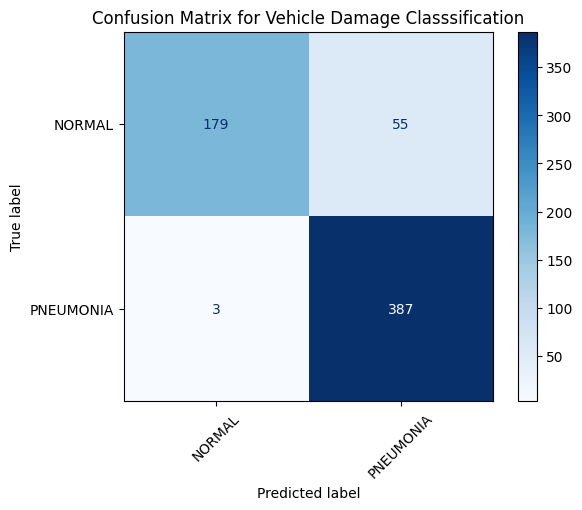

In [110]:
cm = confusion_matrix(all_labels,all_predictions)
disp = ConfusionMatrixDisplay(cm,display_labels=['NORMAL', 'PNEUMONIA'])
disp.plot(cmap= plt.cm.Blues,xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classsification")

### Efficient Net b1

In [ ]:
# import torch
# import torch.nn as nn
# import torchvision.models as models

# class General_efficient_net(nn.Module):
#     def __init__(self,number_classes = 2,input_channels = 3,version = 'b0',freeze_backbone = True,unfreeze_last_block = 2,dropout_rate = 0.5):
#        super().__init__()

#        efficient_variant = {
#            "b0":(models.efficientnet_b0,models.EfficientNet_B0_Weights.DEFAULT),
#            "b1":(models.efficientnet_b1,models.EfficientNet_B1_Weights.DEFAULT),
#            "b2":(models.efficientnet_b2,models.EfficientNet_B2_Weights.DEFAULT),
#            "b3":(models.efficientnet_b3,models.EfficientNet_B3_Weights.DEFAULT),
#            "b4":(models.efficientnet_b4,models.EfficientNet_B4_Weights.DEFAULT),
#            "b5":(models.efficientnet_b5,models.EfficientNet_B5_Weights.DEFAULT),
#            "b6":(models.efficientnet_b6,models.EfficientNet_B6_Weights.DEFAULT),
#            "b7":(models.efficientnet_b7,models.EfficientNet_B7_Weights.DEFAULT),
#        }

#        if version not in efficient_variant:
#            raise ValueError(f"INVALID VALUE ! CHOOSE FROM b0-b7")
       
#        model_fn,weights = efficient_variant[version]
#        self.model = model_fn(weights = weights)

#        old_conv = self.model.features[0][0]
#        new_conv = nn.Conv2d(
#            in_channels=  input_channels,
#            out_channels= old_conv.out_channels,
#            kernel_size= old_conv.kernel_size,
#            stride= old_conv.stride,
#            padding = old_conv.padding,
#            bias = False
#        )

#        # Adapt pretrained weights for non-3-channel inputs
#        if input_channels != 3:
#             with torch.no_grad():
#                 if input_channels == 1:
#                     new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
#                 else:
#                     repeat = input_channels // 3
#                     remainder = input_channels % 3
#                     new_weight = old_conv.weight.repeat(1, repeat, 1, 1)
#                     if remainder > 0:
#                         new_weight = torch.cat(
#                             [new_weight, old_conv.weight[:, :remainder, :, :]], dim=1
#                         )
#                     new_conv.weight[:] = new_weight[:, :input_channels, :, :]

#        self.model.features[0][0] = new_conv

#        ### freezeing the layer

#        if freeze_backbone:
#            for param in self.model.features.parameters():
#                param.requires_grad = False
            
#            total_blocks = len(self.model.features)
#            for i in range(total_blocks-unfreeze_last_block,total_blocks):
#                for param in self.model.features[i].parameters():
#                    param.requires_grad=True


#         ## coustume classifiers

#        in_features = self.model.classifier[1].in_features
#        self.model.classifier = nn.Sequential(
#            nn.Dropout(dropout_rate),
#            nn.Linear(in_features,number_classes)
#        )

#        # 5️⃣ Count trainable parameters

#        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
#        total_params = sum(p.numel() for p in self.parameters())
#        print(f"✅ Loaded EfficientNet-{version.upper()} | "
#               f"Trainable params: {trainable_params:,} / {total_params:,}")
#     def forward(self,x):
#         return self.model(x)



In [ ]:
# model_ef = General_efficient_net(number_classes=2,version='b1',freeze_backbone=True,unfreeze_last_block=2,dropout_rate=0.29608273743261126,input_channels=1).to(device)
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0019902073239981203)
# criterion = nn.CrossEntropyLoss()

✅ Loaded EfficientNet-B1 | Trainable params: 2,695,554 / 6,515,170


In [ ]:
# all_labels,all_predictions = train_model(model=model_ef,optimizer=optimizer,criterion=criterion,device=device,epochs=5,train_loader=train_loader,test_loader=test_loader)

Batch: 10, Epoch: 1, Loss: 0.14
Batch: 20, Epoch: 1, Loss: 0.22
Batch: 30, Epoch: 1, Loss: 0.31
Batch: 40, Epoch: 1, Loss: 0.09
Batch: 50, Epoch: 1, Loss: 0.36
Batch: 60, Epoch: 1, Loss: 0.04
Batch: 70, Epoch: 1, Loss: 0.28
Batch: 80, Epoch: 1, Loss: 0.13
Batch: 90, Epoch: 1, Loss: 0.18
Batch: 100, Epoch: 1, Loss: 0.04
Batch: 110, Epoch: 1, Loss: 0.18
Batch: 120, Epoch: 1, Loss: 0.17
Batch: 130, Epoch: 1, Loss: 0.04
Batch: 140, Epoch: 1, Loss: 0.07
Batch: 150, Epoch: 1, Loss: 0.08
Batch: 160, Epoch: 1, Loss: 0.11
Epoch [1/5], Avg Loss: 0.1544
** Validation Accuracy: 91.83% **

Batch: 10, Epoch: 2, Loss: 0.06
Batch: 20, Epoch: 2, Loss: 0.03
Batch: 30, Epoch: 2, Loss: 0.12
Batch: 40, Epoch: 2, Loss: 0.10
Batch: 50, Epoch: 2, Loss: 0.08
Batch: 60, Epoch: 2, Loss: 0.06
Batch: 70, Epoch: 2, Loss: 0.17
Batch: 80, Epoch: 2, Loss: 0.05
Batch: 90, Epoch: 2, Loss: 0.21
Batch: 100, Epoch: 2, Loss: 0.07
Batch: 110, Epoch: 2, Loss: 0.11
Batch: 120, Epoch: 2, Loss: 0.09
Batch: 130, Epoch: 2, Loss: 0

###   Optuna Hyperparameter Tunning for General Efficient net

In [ ]:
# import optuna
# import torch
# import torch.nn as nn
# import torch.optim as optim

# def objective(trial):
    
#     lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
#     dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)
#     unfreeze_last_block = trial.suggest_int('unfreeze_last_block', 1, 4)

    
#     model = General_efficient_net(number_classes=2,version='b1',freeze_backbone=True,unfreeze_last_block=unfreeze_last_block,dropout_rate=dropout_rate,input_channels=1).to(device)

   
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(
#         filter(lambda p: p.requires_grad, model.parameters()),
#         lr=lr
#     )

#     epochs = 2
#     best_accuracy = 0.0

    
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0

#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * images.size(0)

#         #
#         model.eval()
#         correct, total = 0, 0
#         with torch.no_grad():
#             for images, labels in test_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 _, preds = torch.max(outputs, 1)
#                 total += labels.size(0)
#                 correct += (preds == labels).sum().item()

#         accuracy = 100 * (correct / total)
#         best_accuracy = max(best_accuracy, accuracy)

        
#         trial.report(accuracy, epoch)
#         if trial.should_prune():
#             raise optuna.TrialPruned()

#     return best_accuracy

In [ ]:

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=20)

[I 2025-10-08 09:19:05,864] A new study created in memory with name: no-name-7f4f935e-f920-49ed-9f99-00eee6443315


✅ Loaded EfficientNet-B1 | Trainable params: 5,309,854 / 6,515,170


[I 2025-10-08 09:21:31,717] Trial 0 finished with value: 85.25641025641025 and parameters: {'lr': 1.4419829545149625e-05, 'dropout_rate': 0.20658069464451978, 'unfreeze_last_block': 3}. Best is trial 0 with value: 85.25641025641025.


✅ Loaded EfficientNet-B1 | Trainable params: 5,309,854 / 6,515,170


[I 2025-10-08 09:23:59,747] Trial 1 finished with value: 89.90384615384616 and parameters: {'lr': 3.241377553465377e-05, 'dropout_rate': 0.4151486070687803, 'unfreeze_last_block': 3}. Best is trial 1 with value: 89.90384615384616.


✅ Loaded EfficientNet-B1 | Trainable params: 5,309,854 / 6,515,170


[I 2025-10-08 09:26:24,692] Trial 2 finished with value: 92.94871794871796 and parameters: {'lr': 0.0022567251184973415, 'dropout_rate': 0.6270457078708285, 'unfreeze_last_block': 3}. Best is trial 2 with value: 92.94871794871796.


✅ Loaded EfficientNet-B1 | Trainable params: 414,722 / 6,515,170


[I 2025-10-08 09:28:50,486] Trial 3 finished with value: 87.66025641025641 and parameters: {'lr': 0.00019234828643625594, 'dropout_rate': 0.21261379530769903, 'unfreeze_last_block': 1}. Best is trial 2 with value: 92.94871794871796.


✅ Loaded EfficientNet-B1 | Trainable params: 5,309,854 / 6,515,170


[I 2025-10-08 09:31:18,084] Trial 4 finished with value: 91.66666666666666 and parameters: {'lr': 0.001370522096476718, 'dropout_rate': 0.32968656259328744, 'unfreeze_last_block': 3}. Best is trial 2 with value: 92.94871794871796.


✅ Loaded EfficientNet-B1 | Trainable params: 2,695,554 / 6,515,170


[I 2025-10-08 09:33:42,318] Trial 5 finished with value: 93.91025641025641 and parameters: {'lr': 0.0019902073239981203, 'dropout_rate': 0.29608273743261126, 'unfreeze_last_block': 2}. Best is trial 5 with value: 93.91025641025641.


✅ Loaded EfficientNet-B1 | Trainable params: 5,309,854 / 6,515,170


[I 2025-10-08 09:34:54,720] Trial 6 pruned. 


✅ Loaded EfficientNet-B1 | Trainable params: 2,695,554 / 6,515,170


[I 2025-10-08 09:36:07,864] Trial 7 pruned. 


✅ Loaded EfficientNet-B1 | Trainable params: 2,695,554 / 6,515,170


[I 2025-10-08 09:37:21,287] Trial 8 pruned. 


✅ Loaded EfficientNet-B1 | Trainable params: 414,722 / 6,515,170


[I 2025-10-08 09:38:34,426] Trial 9 pruned. 


✅ Loaded EfficientNet-B1 | Trainable params: 6,061,574 / 6,515,170


[I 2025-10-08 09:40:03,445] Trial 10 pruned. 


✅ Loaded EfficientNet-B1 | Trainable params: 6,061,574 / 6,515,170


[I 2025-10-08 09:43:24,787] Trial 11 finished with value: 92.46794871794873 and parameters: {'lr': 0.0021002098895422116, 'dropout_rate': 0.6973765489454705, 'unfreeze_last_block': 4}. Best is trial 5 with value: 93.91025641025641.


✅ Loaded EfficientNet-B1 | Trainable params: 2,695,554 / 6,515,170


[I 2025-10-08 09:44:37,152] Trial 12 pruned. 


✅ Loaded EfficientNet-B1 | Trainable params: 2,695,554 / 6,515,170


[I 2025-10-08 09:45:48,881] Trial 13 pruned. 


✅ Loaded EfficientNet-B1 | Trainable params: 6,061,574 / 6,515,170


[I 2025-10-08 09:47:01,039] Trial 14 pruned. 


✅ Loaded EfficientNet-B1 | Trainable params: 414,722 / 6,515,170


[I 2025-10-08 09:49:23,620] Trial 15 finished with value: 91.82692307692307 and parameters: {'lr': 0.0033152481884752925, 'dropout_rate': 0.4766407618706397, 'unfreeze_last_block': 1}. Best is trial 5 with value: 93.91025641025641.


✅ Loaded EfficientNet-B1 | Trainable params: 2,695,554 / 6,515,170


[I 2025-10-08 09:51:46,950] Trial 16 finished with value: 92.1474358974359 and parameters: {'lr': 0.0009823574804066226, 'dropout_rate': 0.5921999619059819, 'unfreeze_last_block': 2}. Best is trial 5 with value: 93.91025641025641.


✅ Loaded EfficientNet-B1 | Trainable params: 5,309,854 / 6,515,170


[I 2025-10-08 09:52:59,976] Trial 17 pruned. 


✅ Loaded EfficientNet-B1 | Trainable params: 2,695,554 / 6,515,170


[I 2025-10-08 09:54:11,719] Trial 18 pruned. 


✅ Loaded EfficientNet-B1 | Trainable params: 5,309,854 / 6,515,170


[I 2025-10-08 09:55:23,399] Trial 19 pruned. 


In [ ]:
# study.best_params

{'lr': 0.0019902073239981203,
 'dropout_rate': 0.29608273743261126,
 'unfreeze_last_block': 2}

In [ ]:
# # from sklearn.metrics import classification_report,ConfusionMatrixDisplay ,confusion_matrix
# import numpy as np
# from matplotlib import pyplot as pyplot

# report = classification_report(all_labels,all_predictions)
# print(report)

              precision    recall  f1-score   support

           0       0.95      0.78      0.86       234
           1       0.88      0.98      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624



Text(0.5, 1.0, 'Confusion Matrix for Vehicle Damage Classsification')

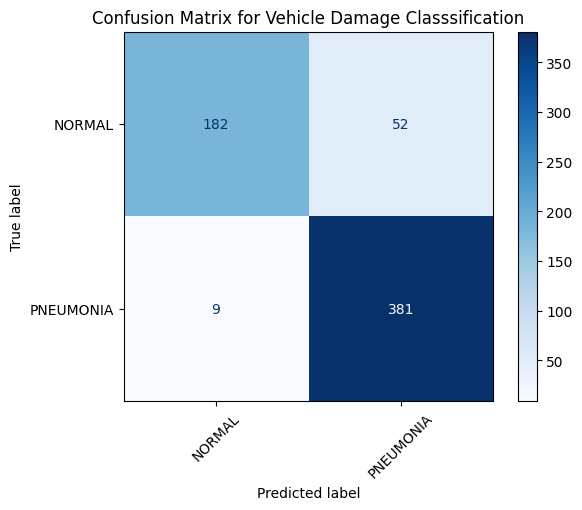

In [ ]:
# cm = confusion_matrix(all_labels,all_predictions)
# disp = ConfusionMatrixDisplay(cm,display_labels=['NORMAL', 'PNEUMONIA'])
# disp.plot(cmap= plt.cm.Blues,xticks_rotation=45)
# plt.title("Confusion Matrix for Vehicle Damage Classsification")